In [2]:
import os
# Change native directory to root three levels up
os.chdir("../../")

In [86]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
from forecast.metrics import *
# plot CRPS scores for each horizon
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import math

n = 75  # Total number of items (0 to 75)
r = 5   # Number of items to be selected

# Calculate the number of combinations
combinations = math.comb(n, r)

print("Number of unique 5-number sets:", combinations)

Number of unique 5-number sets: 17259390


In [8]:
reals = pd.read_csv('debug_logs/real_power_norm_noise_online_9000_1.csv')
reals = reals.iloc[1:, :]
reals = reals.melt(id_vars=['time_step'], var_name='building', value_name='net_target')
reals = reals.sort_values(by=['time_step', 'building'])
reals['building'] = reals['building'].str[-1].astype(int)
reals = reals[reals['time_step'] != -1]
lead_times = ['net_target+'+str(i) for i in range(1, 24)]
reals_h24 = pd.DataFrame()
for building in range(5):
    reals_h24_temp = pd.DataFrame()
    reals_h24_temp['time_step'] = reals.loc[reals['building'] == building, 'time_step']
    reals_h24_temp['building'] = building
    reals_h24_temp['net_target+0'] = reals.loc[reals['building'] == building, 'net_target']
    reals_h24_temp['net_target+0'] = reals_h24_temp['net_target+0'].astype(float)
    for i, lead_time in enumerate(lead_times):
        reals_h24_temp[lead_time] = reals_h24_temp['net_target+0'].shift(-int(i+1))
        reals_h24_temp[lead_time] = reals_h24_temp[lead_time].astype(float)
    reals_h24 = pd.concat([reals_h24, reals_h24_temp], axis=0)
reals_h24 = reals_h24.dropna()
# reals time_step as int
reals_h24 = reals_h24.sort_values(by=['time_step', 'building'])
# set the index to time_step and building
reals_h24 = reals_h24.set_index(['time_step', 'building'], drop=False)
reals_h24

time_step  building  net_target+0  net_target+1  \
time_step building                                                    
0         0                 0         0  8.511667e-01  8.346000e-01   
          1                 0         1  1.370667e+00  1.101250e+00   
          2                 0         2  1.018524e-07  1.008352e-07   
          3                 0         3  1.928167e+00  4.758167e-01   
          4                 0         4  5.158833e-01  5.030500e-01   
...                       ...       ...           ...           ...   
8735      0              8735         0  1.581708e+00  5.796833e-01   
          1              8735         1  2.289758e+00  5.151167e-01   
          2              8735         2  7.067500e-01  4.349000e-01   
          3              8735         3  3.510683e+00  2.099967e+00   
          4              8735         4  1.343600e+00  9.951167e-01   

                    net_target+2  net_target+3  net_target+4  net_target+5  \
time_step building                                                           
0         0         8.381667e-01  1.478433e+00  1.256200e+00      1.811500   
          1         5.432167e-01  5.428333e-01  1.512433e+00      0.326250   
          2         1.007080e-07  1.015981e-07  9.943644e-08     -0.027283   
          3         4.582333e-01  4.460167e-01  4.658833e-01      0.637133   
          4         5.359500e-01  5.126167e-01  3.032167e-01      0.378583   
...                          ...           ...           ...           ...   
8735      0         5.926500e-01  5.763333e-01  5.861833e-01      0.590600   
          1         7.532500e-01  7.767167e-01  1.895200e+00      0.350383   
          2         4.231333e-01  4.464667e-01  3.864667e-01      0.377350   
          3         2.567050e+00  5.842667e-01  7.306833e-01      1.942067   
          4         9.510333e-01  6.088167e-01  5.943000e-01      0.376467   

                    net_target+6  net_target+7  ...  net_target+14  \
time_step building                              ...                  
0         0             0.362733     -0.489917  ...      -0.595117   
          1             0.560617      1.119483  ...       0.935333   
          2            -0.136700     -0.034533  ...      -1.413883   
          3             0.698950      2.152567  ...      -1.972850   
          4             0.274750     -0.070083  ...      -0.109050   
...                          ...           ...  ...            ...   
8735      0             0.770317      0.220983  ...      -0.199817   
          1             0.319250      0.222683  ...       0.944117   
          2             0.314100      0.235600  ...      -1.414011   
          3             0.466517      0.851900  ...       0.192433   
          4             0.444233     -0.149983  ...       0.522200   

                    net_target+15  net_target+16  net_target+17  \
time_step building                                                
0         0             -0.298267       0.059700       1.054850   
          1              0.204017      -0.572450      -0.678733   
          2             -1.743550      -1.656633      -0.879733   
          3             -2.074017      -0.055433       0.160417   
          4             -0.137150       0.023717       2.313683   
...                           ...            ...            ...   
8735      0              0.115850       0.803650       2.636517   
          1              1.083967      -1.310933      -1.106450   
          2             -0.635250      -0.525617       0.284317   
          3             -0.329417       0.222217       1.017867   
          4              1.169617       1.663533       3.119600   

                    net_target+18  net_target+19  net_target+20  \
time_step building                                                
0         0              1.006983   3.603983e+00   5.008500e+00   
          1             -0.069417   3.583334e-01   1.584500e+00   
          2             -0.045

In [9]:
# open csv file for scenarios
scens = pd.read_csv('debug_logs/scenarios_norm_noise_online_9000_1.csv')
scens = scens.set_index(['time_step', 'building'], drop=False)
# remove rows with time_step 8759
scens = scens[scens['time_step'] != 8759]
# keep only indexes that are in reals
scens = scens.loc[reals_h24.index]
scens

time_step  scenario  building       +0h       +1h  \
time_step building                                                      
0         0                 0         0         0  0.410117  0.804187   
          0                 0         1         0  1.256852  1.544893   
          0                 0         2         0  1.600760  0.676636   
          0                 0         3         0  1.685886  1.249810   
          0                 0         4         0  1.501777  0.649180   
...                       ...       ...       ...       ...       ...   
8735      4              8735        70         4  1.286704  0.895030   
          4              8735        71         4  1.123924  1.011616   
          4              8735        72         4  1.145974  0.513954   
          4              8735        73         4  1.169110  2.103064   
          4              8735        74         4  1.381142  1.181840   

                         +2h       +3h       +4h       +5h       +6h  ...  \
time_step building                                                    ...   
0         0         1.335719  1.021933  1.353528  1.165082  0.316009  ...   
          0         1.359125  1.517187  0.912369  0.149285  1.026927  ...   
          0         0.807947  0.711343  1.228043  0.934915  1.145213  ...   
          0         1.146662  0.965514  0.755960  1.038778  0.561009  ...   
          0         1.123638  1.331126  0.928921  1.239043  1.733721  ...   
...                      ...       ...       ...       ...       ...  ...   
8735      4        -0.289048  0.604278 -0.134972 -0.055766  0.223036  ...   
          4         0.529919  1.238654  1.287737 -0.257346 -0.662267  ...   
          4         0.857990  0.909423  0.636722  0.015772  0.687041  ...   
          4         1.020277 -0.207045  1.755092 -0.956669  0.862223  ...   
          4         0.669449 -0.143886  0.940762  1.039008 -0.327153  ...   

                        +14h      +15h      +16h      +17h      +18h  \
time_step building                                                     
0         0        -0.342012  0.629032  0.965417  1.215744  1.465568   
          0        -0.054956  0.559436  0.620309  0.888615  0.997612   
          0         0.549298  0.196884  1.327378  1.918175  1.043269   
          0        -1.228891  0.002154  0.251559  3.147079  0.752136   
          0        -0.286427  0.844493  1.443992  2.338439  1.208933   
...                      ...       ...       ...       ...       ...   
8735      4         0.223648  0.426454  1.634427  2.214854  3.028683   
          4         0.228909  0.613461  1.350355  2.118099  2.896029   
          4         0.206452  0.586214  1.508742  2.013972  2.520894   
          4         0.330172  1.060117  1.671118  2.676734  2.654637   
          4         0.256111  0.941259  1.309442  2.033441  2.679702   

                        +19h      +20h      +21h      +22h      +23h  
time_step building                                                    
0         0         1.208571  2.382846  0.706160  2.101000  2.204445  
          0         0.582008  1.776543  0.563180  1.831808  0.987551  
          0         1.569725  0.965168  1.575737  1.214450  1.178508  
          0         0.906411  2.196011  0.723045  1.779852  1.123499  
          0         1.275657  1.286960  1.759547  1.957263  1.489170  
...                      ...       ...       ...       ...       ...  
8735      4         2.651900  1.183647  0.933850  1.606512  1.276171  
          4         2.208132  1.168189  1.374886  1.243103  1.829292  
          4         2.048239  1.375024  1.180188  1.529185  1.248206  
          4         2.645303  1.329340  1.020708  1.272975  1.680246  
          4         2.419045  1.081834  1.208321  1.988125  1.784976  

[3276000 rows x 27 columns]

In [76]:
scen_point = pd.read_csv('data/together_forecast/phase_1_forecast_sampled_1h.csv')
scen_point = scen_point.set_index(['time_step', 'building'], drop=False)
# remove rows with time_step 8759
scen_point = scen_point[scen_point['time_step'] != 8759]
# keep only indexes that are in reals
scen_point = scen_point.loc[reals_h24.index]
scen_point

time_step  scenario  building       +0h       +1h  \
time_step building                                                      
0         0                 0         0         0  1.315463  0.997405   
          1                 0         0         1  1.250480  0.990671   
          2                 0         0         2  0.334184  0.505538   
          3                 0         0         3  1.501574  1.066869   
          4                 0         0         4  0.761706  0.742030   
...                       ...       ...       ...       ...       ...   
8735      0              8735         0         0  1.307816  0.833908   
          1              8735         0         1  2.570450  1.973022   
          2              8735         0         2  0.745470  0.747448   
          3              8735         0         3  2.593832  2.054581   
          4              8735         0         4  1.120894  0.867890   

                         +2h       +3h       +4h       +5h       +6h  ...  \
time_step building                                                    ...   
0         0         0.882386  0.827967  0.815308  0.853358  0.710826  ...   
          1         0.878696  0.825506  0.813198  0.851392  0.709265  ...   
          2         0.559403  0.592007  0.637254  0.685898  0.604959  ...   
          3         0.904937  0.844253  0.837024  0.860239  0.655470  ...   
          4         0.697915  0.701616  0.719273  0.756398  0.633275  ...   
...                      ...       ...       ...       ...       ...  ...   
8735      0         0.826822  0.847069  0.880363  1.077949  1.134726  ...   
          1         1.362084  0.960358  0.786632  0.642956  0.522123  ...   
          2         0.673948  0.612527  0.557501  0.604905  0.643514  ...   
          3         1.394668  1.206103  1.265229  1.294757  1.034027  ...   
          4         0.747074  0.649337  0.580665  0.561168  0.390262  ...   

                        +14h      +15h      +16h      +17h      +18h  \
time_step building                                                     
0         0        -0.335835  0.450289  0.835517  1.262387  1.473747   
          1        -0.340026  0.449820  0.834876  1.261625  1.473639   
          2        -0.341320  0.449186  0.798859  1.208564  1.391791   
          3        -0.742460  0.219726  0.673009  1.202868  1.476299   
          4        -0.350937  0.439368  0.792496  1.234261  1.410800   
...                      ...       ...       ...       ...       ...   
8735      0        -1.150679 -0.744115 -0.006555  1.370029  2.497657   
          1        -0.171781  0.067596 -0.027369  0.308757  0.668974   
          2        -1.042489 -0.650426 -0.405748  0.204797  0.520217   
          3         0.081814  0.357500  0.404472  1.194380  1.930412   
          4         0.437932  0.896024  1.603932  2.363738  2.783216   

                        +19h      +20h      +21h      +22h      +23h  
time_step building                                                    
0         0         1.314026  1.357523  1.363334  1.404195  1.280302  
          1         1.312518  1.356081  1.361599  1.401595  1.275230  
          2         1.241544  1.262507  1.228239  1.160263  0.833793  
          3         1.326355  1.377343  1.370731  1.424389  1.315757  
          4         1.273827  1.292093  1.267927  1.206125  1.044829  
...                      ...       ...       ...       ...       ...  
8735      0         2.803609  2.987715  2.751516  2.375428  1.927582  
          1         1.427968  1.181158  1.294230  1.402610  1.942418  
          2         1.333799  1.249528  1.178516  1.129053  1.155793  
          3         2.483089  1.357712  1.605706  2.051101  2.274746  
          4         2.326213  1.121863  1.145607  1.538900  1.463096  

[43680 rows x 27 columns]

In [10]:
# get row entries with first 5 scenarios 
scens_5 = scens[scens['scenario'] < 5].copy()
scens_5_10 = scens[(scens['scenario'] >= 5) & (scens['scenario'] < 10)].copy()
scens_5

time_step  scenario  building       +0h       +1h  \
time_step building                                                      
0         0                 0         0         0  0.410117  0.804187   
          0                 0         1         0  1.256852  1.544893   
          0                 0         2         0  1.600760  0.676636   
          0                 0         3         0  1.685886  1.249810   
          0                 0         4         0  1.501777  0.649180   
...                       ...       ...       ...       ...       ...   
8735      4              8735         0         4  0.976734  0.939478   
          4              8735         1         4  1.009888  1.136187   
          4              8735         2         4  1.041364  0.844456   
          4              8735         3         4  1.013010  0.948192   
          4              8735         4         4  1.173492  0.781688   

                         +2h       +3h       +4h       +5h       +6h  ...  \
time_step building                                                    ...   
0         0         1.335719  1.021933  1.353528  1.165082  0.316009  ...   
          0         1.359125  1.517187  0.912369  0.149285  1.026927  ...   
          0         0.807947  0.711343  1.228043  0.934915  1.145213  ...   
          0         1.146662  0.965514  0.755960  1.038778  0.561009  ...   
          0         1.123638  1.331126  0.928921  1.239043  1.733721  ...   
...                      ...       ...       ...       ...       ...  ...   
8735      4        -0.225899  0.356054  0.628935  1.178167  0.291550  ...   
          4         1.106677  1.255081  0.111988  0.448751  0.687387  ...   
          4         0.888534  0.504985  1.148816  1.615409  0.699129  ...   
          4         0.994641  1.043264  1.109137  0.739013 -0.180305  ...   
          4         1.103903 -0.152045  1.993584  0.832991 -0.639935  ...   

                        +14h      +15h      +16h      +17h      +18h  \
time_step building                                                     
0         0        -0.342012  0.629032  0.965417  1.215744  1.465568   
          0        -0.054956  0.559436  0.620309  0.888615  0.997612   
          0         0.549298  0.196884  1.327378  1.918175  1.043269   
          0        -1.228891  0.002154  0.251559  3.147079  0.752136   
          0        -0.286427  0.844493  1.443992  2.338439  1.208933   
...                      ...       ...       ...       ...       ...   
8735      4         0.713830  0.546838  1.698523  2.484827  2.524536   
          4         0.554641  0.677353  1.651781  2.493323  3.044374   
          4         0.633632  1.153723  2.208587  2.214169  2.760163   
          4         0.543631  1.613743  1.546164  2.232629  2.602314   
          4         0.306716  1.295183  2.008710  2.427365  2.946649   

                        +19h      +20h      +21h      +22h      +23h  
time_step building                                                    
0         0         1.208571  2.382846  0.706160  2.101000  2.204445  
          0         0.582008  1.776543  0.563180  1.831808  0.987551  
          0         1.569725  0.965168  1.575737  1.214450  1.178508  
          0         0.906411  2.196011  0.723045  1.779852  1.123499  
          0         1.275657  1.286960  1.759547  1.957263  1.489170  
...                      ...       ...       ...       ...       ...  
8735      4         2.457165  1.162125  1.168443  1.245216  0.873894  
          4         2.296358  1.293096  1.143136  1.305324  1.334252  
          4         2.486128  0.956330  1.339427  1.793627  0.900341  
          4         1.776333  1.362338  1.134205  1.549586  1.489085  
          4         2.160031  1.049724  0.912502  1.449600  1.817054  

[218400 rows x 27 columns]

In [11]:
bins_5 = rank_bins(scens_5, reals_h24)

In [69]:
bins_5_10 = rank_bins(scens_5_10, reals_h24)

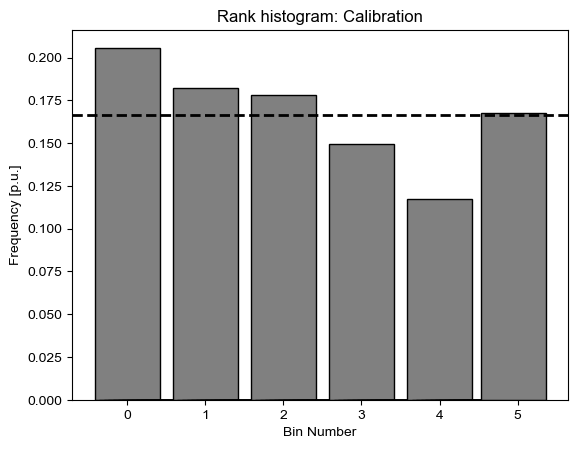

In [12]:
plot_bins(bins_5)

In [13]:
rank_bins_metric(bins_5)

0.04332213212888752

In [87]:
mean_errs = mean_ensemble_error(scens_5)

TypeError: mean_ensemble_error() missing 1 required positional argument: 'reals'

In [71]:
mean_err = discrete_mean_ensemble_error(scens_5)
mean_err

-3.023587010936376e-20

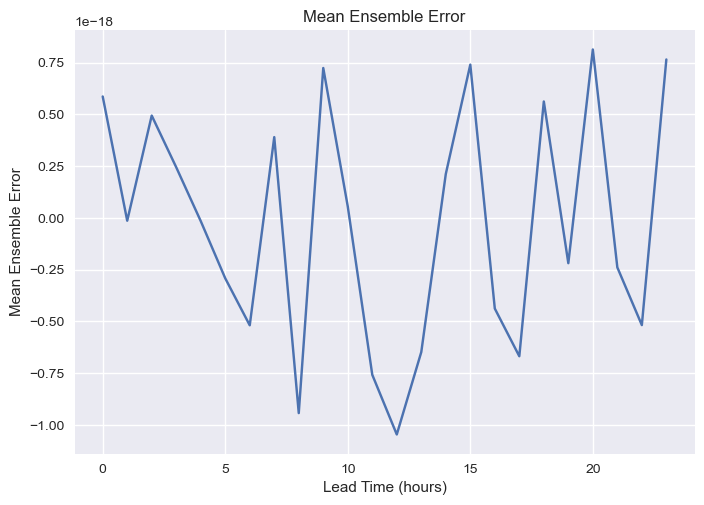

In [66]:
# plot dict of mean errors with keys as lead times and values as mean errors
plt.plot(list(mean_errs.keys()), list(mean_errs.values()))
plt.title('Mean Ensemble Error')
plt.xlabel('Lead Time (hours)')
plt.ylabel('Mean Ensemble Error')
plt.show()

In [84]:
mean_stds = ensemble_std(scens_5)
mean_stds

{0: 1.141958106164399,
 1: 1.1881039570061431,
 2: 1.1918309423069862,
 3: 1.1994656749964856,
 4: 1.2027710671819751,
 5: 1.198668309247676,
 6: 1.2010190629828081,
 7: 1.2000923685095506,
 8: 1.1908319899766178,
 9: 1.1838228119534773,
 10: 1.17676603409552,
 11: 1.1554004042257944,
 12: 1.1574863144783307,
 13: 1.1846808687570067,
 14: 1.191589694332983,
 15: 1.200616863099156,
 16: 1.2031785311118215,
 17: 1.2036950996543307,
 18: 1.2034881391797059,
 19: 1.2074273539896048,
 20: 1.2038788453704288,
 21: 1.1981939104960104,
 22: 1.1963248333892258,
 23: 1.1887089165330784}

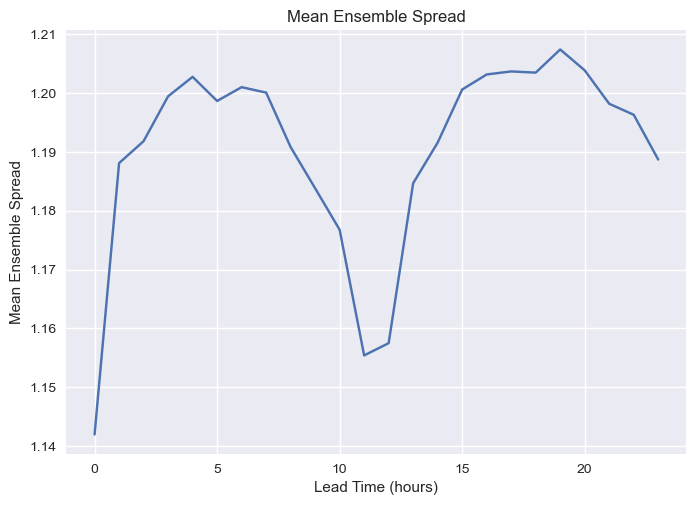

In [85]:
# plot dict of mean errors with keys as lead times and values as mean errors
plt.plot(list(mean_stds.keys()), list(mean_stds.values()))
plt.title('Mean Ensemble Spread')
plt.xlabel('Lead Time (hours)')
plt.ylabel('Mean Ensemble Spread')
plt.show()

In [82]:
mean_point_std = ensemble_std(scen_point)
mean_point_std

{0: 1.0443068372533424,
 1: 1.013920749295114,
 2: 1.0058919257856318,
 3: 1.0025631152161076,
 4: 1.0006377644346849,
 5: 0.9992414349226989,
 6: 0.9985857796364307,
 7: 0.9984393910769057,
 8: 0.9976622750380637,
 9: 0.9969105171200827,
 10: 0.9965768053300325,
 11: 0.9968825669440401,
 12: 0.9966116209309988,
 13: 0.9968639279065543,
 14: 0.9961788515278631,
 15: 0.9965270743118649,
 16: 0.9971820268924081,
 17: 0.9971063729059727,
 18: 0.996934804765044,
 19: 0.9966284283881979,
 20: 0.9959195107380726,
 21: 0.9954237776205502,
 22: 0.9947574183767998,
 23: 0.9937871993011379}

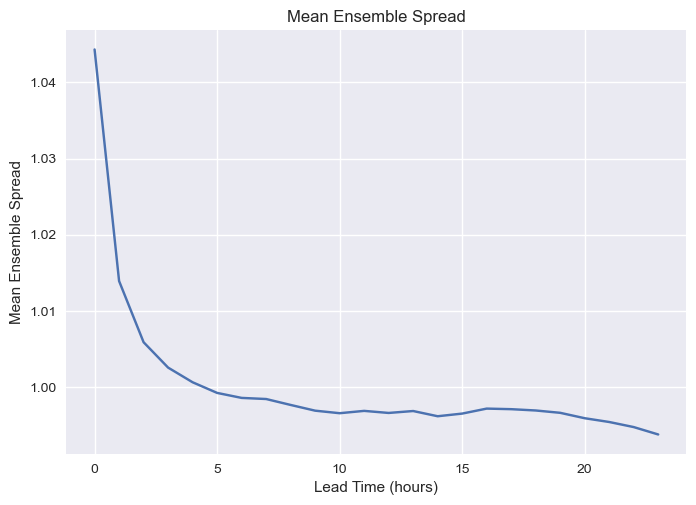

In [83]:
# plot dict of mean errors with keys as lead times and values as mean errors
plt.plot(list(mean_point_std.keys()), list(mean_point_std.values()))
plt.title('Mean Ensemble Spread')
plt.xlabel('Lead Time (hours)')
plt.ylabel('Mean Ensemble Spread')
plt.show()

In [80]:
scen_point

time_step  scenario  building       +0h       +1h  \
time_step building                                                      
0         0                 0         0         0  1.315463  0.997405   
          1                 0         0         1  1.250480  0.990671   
          2                 0         0         2  0.334184  0.505538   
          3                 0         0         3  1.501574  1.066869   
          4                 0         0         4  0.761706  0.742030   
...                       ...       ...       ...       ...       ...   
8735      0              8735         0         0  1.307816  0.833908   
          1              8735         0         1  2.570450  1.973022   
          2              8735         0         2  0.745470  0.747448   
          3              8735         0         3  2.593832  2.054581   
          4              8735         0         4  1.120894  0.867890   

                         +2h       +3h       +4h       +5h       +6h  ...  \
time_step building                                                    ...   
0         0         0.882386  0.827967  0.815308  0.853358  0.710826  ...   
          1         0.878696  0.825506  0.813198  0.851392  0.709265  ...   
          2         0.559403  0.592007  0.637254  0.685898  0.604959  ...   
          3         0.904937  0.844253  0.837024  0.860239  0.655470  ...   
          4         0.697915  0.701616  0.719273  0.756398  0.633275  ...   
...                      ...       ...       ...       ...       ...  ...   
8735      0         0.826822  0.847069  0.880363  1.077949  1.134726  ...   
          1         1.362084  0.960358  0.786632  0.642956  0.522123  ...   
          2         0.673948  0.612527  0.557501  0.604905  0.643514  ...   
          3         1.394668  1.206103  1.265229  1.294757  1.034027  ...   
          4         0.747074  0.649337  0.580665  0.561168  0.390262  ...   

                        +14h      +15h      +16h      +17h      +18h  \
time_step building                                                     
0         0        -0.335835  0.450289  0.835517  1.262387  1.473747   
          1        -0.340026  0.449820  0.834876  1.261625  1.473639   
          2        -0.341320  0.449186  0.798859  1.208564  1.391791   
          3        -0.742460  0.219726  0.673009  1.202868  1.476299   
          4        -0.350937  0.439368  0.792496  1.234261  1.410800   
...                      ...       ...       ...       ...       ...   
8735      0        -1.150679 -0.744115 -0.006555  1.370029  2.497657   
          1        -0.171781  0.067596 -0.027369  0.308757  0.668974   
          2        -1.042489 -0.650426 -0.405748  0.204797  0.520217   
          3         0.081814  0.357500  0.404472  1.194380  1.930412   
          4         0.437932  0.896024  1.603932  2.363738  2.783216   

                        +19h      +20h      +21h      +22h      +23h  
time_step building                                                    
0         0         1.314026  1.357523  1.363334  1.404195  1.280302  
          1         1.312518  1.356081  1.361599  1.401595  1.275230  
          2         1.241544  1.262507  1.228239  1.160263  0.833793  
          3         1.326355  1.377343  1.370731  1.424389  1.315757  
          4         1.273827  1.292093  1.267927  1.206125  1.044829  
...                      ...       ...       ...       ...       ...  
8735      0         2.803609  2.987715  2.751516  2.375428  1.927582  
          1         1.427968  1.181158  1.294230  1.402610  1.942418  
          2         1.333799  1.249528  1.178516  1.129053  1.155793  
          3         2.483089  1.357712  1.605706  2.051101  2.274746  
          4         2.326213  1.121863  1.145607  1.538900  1.463096  

[43680 rows x 27 columns]